src : [Micrograd tutorial by Andrej](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1)


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from graphviz import Digraph

what is a derivative?

For a curve y = f(x), the derivative at a point x0 tells us how y changes around x0, if x0 changes a little bit. When done continuously, it is the instantaneous rate of change of a function. Using the limit definition of a derivative, for a small h (technically as h tends towards zero, but in a computer, is not suuper close because of floating point representation of a number), the derivative of y at a point x0 is (f(x0+h)-(xo))/h.

For a function dependant on many variables, like z = f(a,b,c,d), the _partial_ derivative dz/da tells us how z changes when a varies a little bit, and similarly for the other variables.

This can be generalised for nested variable dependancies using the chain rule.
d = f(a,b,c)
k = f(d,e,f)
z = f(k,x,y)

dz/da = how z changes when the leaf node a changes = dz/dk \* dk/dd \* dd/da


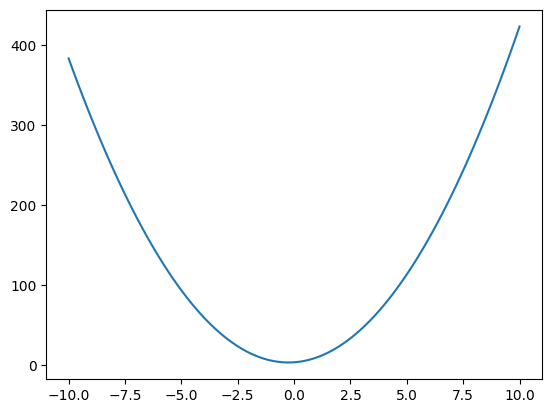

In [7]:
def f(x):
    return 4 * x**2 + 2 * x + 3


def fprime(x):
    return 8 * x + 2


xs = np.linspace(-10, 10, 100)
plt.plot(xs, f(xs))

In [8]:
x0 = -7.5
real_der = fprime(x0)
h = 0.0001
numerical_der = (f(x0 + h) - f(x0)) / h
print(f"real : {real_der}\nnumerical : {numerical_der} ")

real : -58.0
numerical : -57.999599999902784 


In [9]:
# for a bit more complex, nested case
a = 2
b = 3
c = a * b
d = c + 78

print(d)
h = 0.0001
# dd/da
a = 2 + h
b = 3
c = a * b
d2 = c + 78


print(f"real : {b}\nnumerical : {(d2 - d) / h} ")

84
real : 3
numerical : 2.999999999957481 


In [132]:
class Value:
    def __init__(self, data, _children=(), _op="") -> None:
        self.data = data
        self._children = _children
        self._op = _op
        self.label = ""
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        res = Value(self.data + other.data, _children=(self, other), _op="+")

        def _backward():
            # my parent p = (me + other)
            # my local gradient is dp/dme =1
            # global gradient is dL/dme = my local gradient * my parent's gradient
            # res.grad is set later, thats why this is in a function to be called later
            # '+' distributes the parent gradient to its children
            self.grad += 1 * res.grad
            other.grad += 1 * res.grad

        # children of this new object combined with 'op' give this value
        res._backward = _backward
        return res

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        # other = other if isinstance(other, Value) else Value(other)
        # res = Value(self.data - other.data, _children=(self, other), _op="-")

        # def _backward():
        #     self.grad += 1 * res.grad
        #     other.grad += -1 * res.grad

        # # children of this new object combined with 'op' give this value
        # res._backward = _backward
        # return res
        return self + (other * -1)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        res = Value(self.data * other.data, _children=(self, other), _op="*")

        def _backward():
            self.grad += other.data * res.grad
            other.grad += self.data * res.grad

        res._backward = _backward
        return res

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        # other = other if isinstance(other, Value) else Value(other)
        # res = Value(self.data / other.data, _children=(self, other), _op="/")

        # def _backward():
        #     self.grad += res.grad * (1 / other.data)
        #     other.grad += res.grad * (1 / self.data)

        # res._backward = _backward
        # return res

        # or, can use pow
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        res = Value(self.data**other, _children=(self, other), _op=f"**{other}")

        def _backward():
            self.grad += res.grad * (other * (self.data ** (other - 1)))

        res._backward = _backward
        return res

    def exp(self):
        res = Value(np.exp(self.data), _children=(self,), _op="exp")

        def _backward():
            self.grad += res.grad * res.data

        res._backward = _backward
        return res

    def tanh(self):
        # we dont always have to implement the most elementary operations
        # anything goes as long as you can differentiate through it, via the local
        # derivative you define.
        res = Value(np.tanh(self.data), _children=(self,), _op="tanh")
        # can break it into elementary opes if you want tho
        # res = Value(
        #     (((self * 2).exp() - 1) / ((self * 2).exp() + 1)).data,
        #     _children=(self,),
        #     _op="tanh",
        # )

        def _backward():
            # parents grad times it's own grad (via https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives)
            self.grad += res.grad * (1 - res.data**2)

        res._backward = _backward
        return res

    def backward(self):
        # backpropagate treating this as the root
        # we use a queue here so that the gradient of the parents are computed first, then the children
        self.grad = 1
        queue = [self]
        while len(queue) != 0:
            cur = queue.pop(0)  # FIFO
            # will update the gradients of my children wrt the root using me for chain rule
            cur._backward()
            for c in cur._children:
                queue.append(c)

In [119]:
a = Value(2)
b = Value(3)
c = a * b
d = Value(78)
e = c + d
a.label = "a"
b.label = "b"
c.label = "c"
d.label = "d"
e.label = "e"
e

Value(data=84)

In [105]:
e.backward()
a.grad

3

In [53]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format="svg", rankdir="LR"):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ["LR", "TB"]
    nodes, edges = trace(root)
    dot = Digraph(
        format=format, graph_attr={"rankdir": rankdir}
    )  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(
            name=str(id(n)),
            label="{ %s| %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [60]:
e.grad = 1  # de/de = 1. it changes proportional to itself when its own value varies
d.grad = 1  # de/dd = 1. d is a constant, and it directly and proportionately impacts e
c.grad = 1  # same as above
# chain rule and product rule. de/db = de/dc * dc/db. dc/db = d(ab)/db = a
b.grad = c.grad * a.data
a.grad = c.grad * b.data

# a,b are leaf nodes, and can be weights, and their gradient (wrt loss e for example), tells us how to change them to in order to increase/decrease the loss.

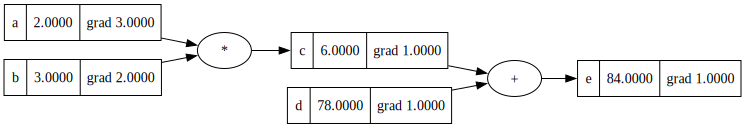

In [106]:
draw_dot(e)

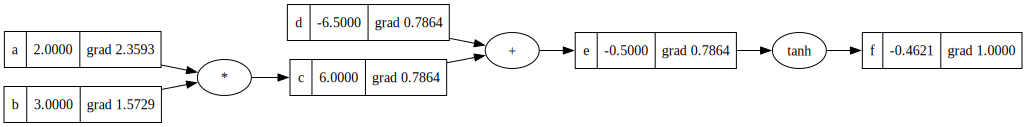

In [133]:
a = Value(2)
b = Value(3)
c = a * b
d = Value(-6.5)
e = c + d
f = e.tanh()
a.label = "a"
b.label = "b"
c.label = "c"
d.label = "d"
e.label = "e"
f.label = "f"

f.backward()
draw_dot(f)

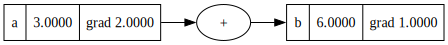

In [118]:
a = Value(3)
b = a + a

a.label = "a"
b.label = "b"
b.backward()
draw_dot(b)

In [116]:
b._children

(Value(data=3), Value(data=3))